# 1.0 Boosting

**Boosting** (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are **AdaBoost** (short for Adaptive Boosting) and **Gradient Boosting**. Let’s start with AdaBoost.

## 1.1 AdaBoost

One way for a new predictor to correct its predecessor is to **pay a bit more attention to the training instances that the predecessor underfitted**. This results in new predictors focusing more and more on the hard cases. This is the technique used by **AdaBoost**.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

<img width="500" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1xAz0-6kXiScOPwpiuc9eHfFz3YwHJWxh">

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

In [0]:
# source: https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

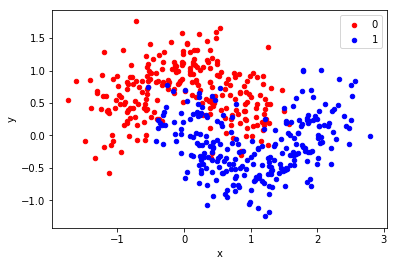

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import pandas as pd
import matplotlib.pyplot as plt

# generate 2d classification dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [0]:
# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

Scikit-Learn actually uses a multiclass version of [AdaBoost called SAMME](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the
predictors can estimate class probabilities (i.e., if they have a **predict_proba()**
method), Scikit-Learn can use a variant of SAMME called **SAMME.R** (the R stands for "Real"), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an Ada BoostRegressor class). A Decision Stump is a Decision Tree with **max_depth=1**, in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class.

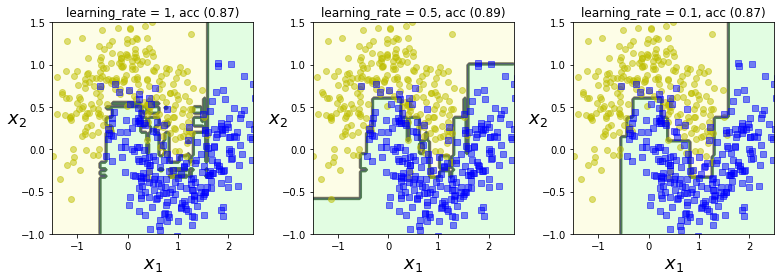

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

plt.figure(figsize=(11, 4))

for subplot, learning_rate in ((131, 1), (132, 0.5), (133, 0.1)):
  plt.subplot(subplot)
  ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                             n_estimators=200,
                             algorithm="SAMME.R", 
                             learning_rate=learning_rate, 
                             random_state=42)
  ada_clf.fit(X_train, y_train)
  plot_decision_boundary(ada_clf, X, y)

  plt.title("learning_rate = {0}, acc ({1})".format(learning_rate,
                                                    accuracy_score(y_test,ada_clf.predict(X_test))),
            fontsize=12)

plt.tight_layout()
plt.show()


## 1.2 Gradient Boosting


Another very popular Boosting algorithm is **Gradient Boosting**. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, **this method tries to fit the new predictor to the residual errors made by the previous predictor**.

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with classification tasks). This is called **Gradient Tree Boosting**, or **Gradient Boosted Regression Trees (GBRT)**. First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):

In [0]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

# create a simple DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [0]:
# now train a second DecisionTreeRegressor 
# on the residual errors made by the first predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [0]:
# then we train a third regressor on the residual errors
# made by the second predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [0]:
X_new = np.array([[0.6]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first
two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

In [0]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

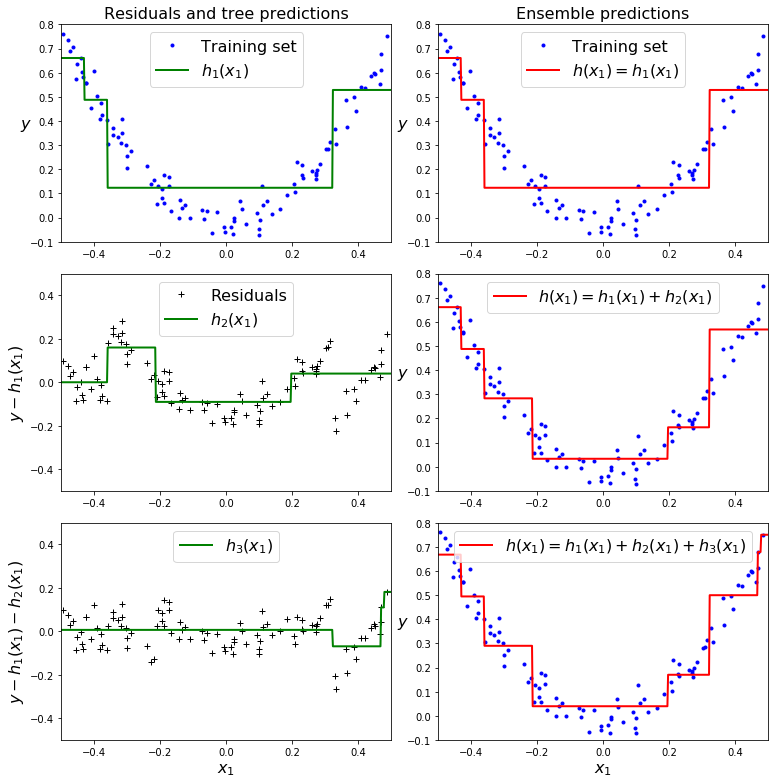

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.tight_layout()
plt.show()

A simpler way to train GBRT ensembles is to use Scikit-Learn’s [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class. Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (e.g., **max_depth**, **min_samples_leaf**, and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (**n_estimators**). The following code creates the same ensemble as the previous one:

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=3, 
                                 learning_rate=1.0, 
                                 random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

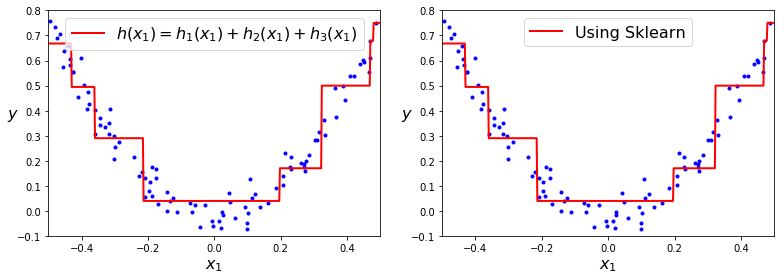

In [0]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# learning rate = 1
# n_estimators = 3
plt.subplot(122)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Using Sklearn")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.tight_layout()
plt.show()

The **learning_rate** hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique
called **shrinkage**. Figure below shows two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

In [0]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

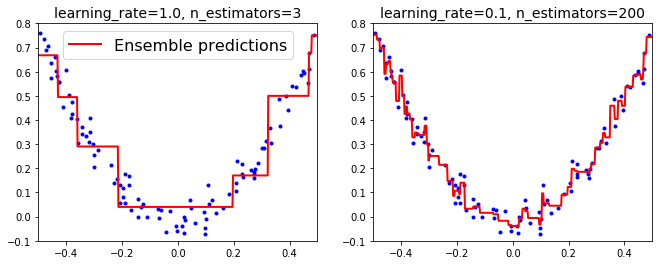

In [0]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

### 1.2.1 Early stopping

In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the **staged_predict()** method: it
returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) 
            for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
min_error = np.min(errors)
min_error

0.002712853325235463

Minimum validation MSE: 0.002712853325235463


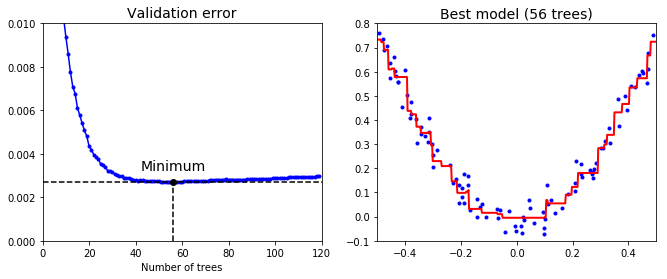

In [0]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

print("Minimum validation MSE:", mean_squared_error(y_test, gbrt_best.predict(X_test)))

plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting **warm_start=True**, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:

In [0]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [0]:
print(gbrt.n_estimators)

61


In [0]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


The GradientBoostingRegressor class also supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For example, if **subsample=0.25**, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called **Stochastic Gradient Boosting**.

### 1.2.2 Improvements to Basic Gradient Boosting

Gradient boosting is a greedy algorithm and can overfit a training dataset quickly. It can benefit from regularization methods that penalize various parts of the algorithm and generally improve the performance of the algorithm by reducing overfitting. In this this section we will look at [four
enhancements to basic gradient boosting](https://arxiv.org/pdf/1603.02754.pdf):

1. Tree Constraints.
2. Shrinkage.
3. Random Sampling.
4. Penalized Gradient Boosting.

**Tree Constraints**

It is important that the **weak learners have skill but remain weak**. There are a number of ways that the trees can be constrained. A good general heuristic is that the more constrained tree creation is, the more trees you will need in the model, and the reverse, where less constrained
individual trees, the fewer trees that will be required. Below are some constraints that can be imposed on the construction of decision trees:

- The advice is to keep adding trees until no further improvement is observed.
- Tree depth, deeper trees are more complex trees and shorter trees are preferred. Generally, better results are seen with 4-8 levels.
- Number of observations per split imposes a minimum constraint on the amount of training data at a training node before a split can be considered.

**Weighted Updates**

The predictions of each tree are added together sequentially. The contribution of each tree to this sum can be weighted to slow down the learning by the algorithm. This weighting is called a **shrinkage** or a **learning rate**.

The effect is that learning is slowed down, in turn require more trees to be added to the model, in turn taking longer to train, providing a configuration trade-off between the number of trees and learning rate.

- Decreasing the value of the learning rate increases the best value for the
number of trees.
- It is common to have small values for learning rate in the range of 0.1 to 0.3, as well as values less than 0.1.

Similar to a learning rate in stochastic optimization, shrinkage reduces the influence of each individual tree and leaves space for future trees to improve the model.

**Stochastic Gradient**

A big insight into bagging ensembles and random forest was allowing trees to be greedily created from subsamples of the training dataset. This same benefit can be used to reduce the correlation between the trees in the sequence in gradient boosting models. This variation of boosting is called **stochastic gradient boosting**

- at each iteration a subsample of the training data is drawn at random (without replacement) from the full training dataset. The randomly selected subsample is then used, instead of the full sample, to fit the base learner.
- generally, aggressive sub-sampling such as selecting only 50% of the data has shown to be beneficial.

A few variants of stochastic boosting that can be used:

- Subsample rows before creating each tree.
- Subsample columns before creating each tree
- Subsample columns before considering each split.

**Penalized Gradient Boosting**

Additional constraints can be imposed on the parameterized trees in addition to their structure. Classical decision trees like CART are not used as weak learners, instead a modified form called a regression tree is used that has numeric values in the leaf nodes (also called terminal nodes). The values in the leaves of the trees can be called weights in some literature. As such, the leaf weight values of the trees can be regularized using popular regularization functions, such as:

- $L^1$ regularization of weights.
- $L^2$ regularization of weights.

The additional regularization term helps to smooth the nal learnt weights to
avoid over-tting. Intuitively, the regularized objective will tend to select a model employing simple and predictive functions.


## 1.3 eXtreme Gradient Boosting (XGboost)

XGBoost is an algorithm that has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

XGBoost stands for **eXtreme Gradient Boosting**. The name XGBoost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why
many people use XGBoost.

It is an implementation of gradient boosting machines created by [Tianqi Chen](https://arxiv.org/abs/1603.02754), now with contributions from many developers. It belongs to a broader collection of tools under the umbrella of the Distributed Machine Learning Community or DMLC who are also the creators of the popular mxnet deep learning library. Tianqi Chen provides a brief and interesting back
story on the creation of XGBoost in the tutorial Story and Lessons Behind the [Evolution of XGBoost](https://homes.cs.washington.edu/~tqchen/2016/03/10/story-and-lessons-behind-the-evolution-of-xgboost.html). XGBoost is a software library that you can download and install on your machine, then access from a variety of interfaces. Specically XGBoost supports the following main interfaces:

- Command Line Interface (CLI).
- C++ (the language in which the library is written).
- Python interface as well as a model in scikit-learn.
- R interface as well as a model in the caret package.
- Julia support.
- Java and JVM languages like Scala and platforms like Hadoop.

### 1.3.1 XGBoost Features

The library is laser focused on computational speed and model performance, as such there are few frills. Nevertheless, it does oer a number of advanced features.

The implementation of the model supports the features of the scikit-learn and R implementations, with new additions like regularization. Three main forms of gradient boosting are supported:

- Gradient Boosting algorithm also called gradient boosting machine including the learning rate.
- Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels.
- Regularized Gradient Boosting with both $L^1$ and $L^2$ regularization.

The library provides a system for use in a range of computing environments, not least:
- Parallelization of tree construction using all of your CPU cores during training.
- Distributed Computing for training very large models using a cluster of machines.
- Out-of-Core Computing for very large datasets that don't t into memory.
- Cache Optimization of data structures and algorithm to make best use of hardware.

### 1.3.2 Why Use XGBoost?

The two reasons to use XGBoost are:

- Execution Speed
- Model Performance

Generally, XGBoost is fast. Really fast when compared to other implementations of gradient boosting. Szilard Pafka performed some objective benchmarks comparing the performance of XGBoost to other implementations of gradient boosting and bagged decision trees. He wrote up his results in May 2015 in the blog tutorial titled [Benchmarking Random Forest
Implementations](http://datascience.la/benchmarking-random-forest-implementations/). He also provides all the [code on GitHub](https://github.com/szilard/benchm-ml) and a more extensive report of results with hard numbers. His results showed that XGBoost was almost always faster than the other benchmarked
implementations from R, Python Spark and H2O.

### 1.3.3 Case Study: using Sklearn Wrapper




We'll continue using the same 1994 census data set on U.S. income. It contains information on **marital status**, **age**, **type of work**, and **more**. The target column, **high_income**, records salaries less than or equal to 50k a year (0), and more than 50k a year (1).

You can download the data from the [University of California](http://archive.ics.uci.edu/ml/datasets/Adult), Irvine's website.

#### Load Libraries


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pydotplus
from IPython.display import Image
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import time
import xgboost as xgb

#### Get the data

In [0]:
import pandas as pd

# load the dataset
income = pd.read_csv("income.csv")
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
# verifying if there are missing values
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
high_income       32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


#### Clean, prepare and manipulate Data (feature engineering)

This dataset contains a mix of **categorical (9 columns)** and **numerical (6 columns)** independent variables which as we know will need to pre-processed in different ways and separately.

This means that initially they’ll have to go through **separate pipelines** to be pre-processed appropriately and then we’ll combine them together. So the first step in both pipelines would have to be to extract the appropriate columns that need to be pushed down for pre-processing.

In [0]:
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
col = pd.Categorical(income.high_income)
income["high_income"] = col.codes

In [0]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ] 

**Categorical Pipeline**

In [0]:
#converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
  #Class constructor method that takes a boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    if self.new_features:
      # Treat ? workclass as unknown
      df['workclass']= df['workclass'].replace('?','Unknown') 
      # Two many category level, convert just US and Non-US
      df.loc[df['native_country']!=' United-States','native_country'] = 'non_usa' 

    # convert columns to categorical
    for name in df.columns.to_list():
      col = pd.Categorical(df[name])
      df[name] = col.codes
    
    #returns numpy array
    return df

In [0]:
# for validation purposes
# model = CategoricalTransformer(new_features=True)
# df = model.transform(income.drop(labels=["high_income"],axis=1))

In [0]:
# for validation purposes
# model = FeatureSelector(income.select_dtypes("object").columns.to_list())
# df = model.transform(income.drop(labels=["high_income"],axis=1))

#### Modeling (train and test)

In [0]:
# global varibles
seed = 42
num_folds = 10
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [0]:
# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(income.drop(labels="high_income",axis=1),
                                                    income["high_income"],
                                                    test_size=0.20,
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=income["high_income"])

In [0]:
# Categrical features to pass down the categorical pipeline 
categorical_features = income.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = income.select_dtypes("int64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer())
                                         ]
                                )
# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('std_scaler', MinMaxScaler()) 
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('categorical_pipeline', categorical_pipeline),
                                                               ('numerical_pipeline', numerical_pipeline)
                                                               ]
                                           )

In [0]:
# for validate purposes
new_data = full_pipeline_preprocessing.fit_transform(X_train)
new_data_df = pd.DataFrame(new_data,columns = categorical_features + numerical_features)
new_data_df.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,4.0,9.0,2.0,4.0,0.0,4.0,1.0,0.0,0.205479,0.016928,0.800000,0.000000,0.0,0.448980
1,4.0,12.0,4.0,4.0,1.0,4.0,0.0,0.0,0.356164,0.060896,0.866667,0.000000,0.0,0.448980
2,0.0,11.0,4.0,0.0,1.0,4.0,0.0,0.0,0.041096,0.074679,0.533333,0.000000,0.0,0.275510
3,2.0,15.0,0.0,14.0,4.0,4.0,1.0,0.0,0.315068,0.008474,0.600000,0.068491,0.0,0.397959
4,4.0,9.0,4.0,10.0,3.0,4.0,1.0,0.0,0.095890,0.069037,0.800000,0.000000,0.0,0.397959


#### Algorithm Tuning

In [0]:
# The full pipeline as a step in another pipeline with an estimator as the final step
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs",SelectKBest()),
                         ("clf",XGBClassifier())])

# create a dictionary with the hyperparameters
search_space = [
                {"clf":[RandomForestClassifier()],
                 "clf__n_estimators": [200],
                 "clf__criterion": ["entropy"],
                 "clf__max_leaf_nodes": [128],
                 "clf__random_state": [seed],
                 "fs__score_func":[chi2],
                 "fs__k":[13]},
                {"clf":[XGBClassifier()],
                 "clf__n_estimators": [100,200],
                 "clf__max_depth": [4],
                 "clf__learning_rate": [0.1],
                 "clf__random_state": [seed],
                 "clf__subsample": [1],
                 "clf__colsample_bytree": [1.0],
                 "fs__score_func":[chi2],
                 "fs__k":[13]}
                ]

# create grid search
kfold = KFold(n_splits=num_folds,random_state=seed)

# return_train_score=True
# official documentation: "computing the scores on the training set can be
# computationally expensive and is not strictly required to
# select the parameters that yield the best generalization performance".
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="AUC")
tmp = time.time()

# fit grid search
best_model = grid.fit(X_train,y_train)

print("CPU Training Time: %s seconds" % (str(time.time() - tmp)))

CPU Training Time: 68.71298003196716 seconds


In [0]:
print("Best: %f using %s" % (best_model.best_score_,best_model.best_params_))

Best: 0.921564 using {'clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__random_state': 42, 'clf__subsample': 1, 'fs__k': 13, 'fs__score_func': <function chi2 at 0x7fe9ca1599d8>}


In [0]:
result = pd.DataFrame(best_model.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__criterion,param_clf__max_leaf_nodes,param_clf__n_estimators,param_clf__random_state,param_fs__k,param_fs__score_func,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_depth,param_clf__subsample,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,split5_test_AUC,split6_test_AUC,split7_test_AUC,split8_test_AUC,split9_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,split5_train_AUC,split6_train_AUC,split7_train_AUC,split8_train_AUC,split9_train_AUC,mean_train_AUC,std_train_AUC,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,split5_test_Accuracy,split6_test_Accuracy,split7_test_Accuracy,split8_test_Accuracy,split9_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,split5_train_Accuracy,split6_train_Accuracy,split7_train_Accuracy,split8_train_Accuracy,split9_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,3.636574,0.028000,0.238388,0.002481,"RandomForestClassifier(bootstrap=True, class_w...",entropy,128,200,42,13,<function chi2 at 0x7fe9ca1599d8>,NaN,NaN,NaN,NaN,"{'clf': RandomForestClassifier(bootstrap=True,...",0.918610,0.911203,0.913516,0.909162,0.925699,0.917564,0.913160,0.902687,0.905697,0.917694,0.913500,0.006411,3,0.928160,0.927711,0.928000,0.927791,0.926678,0.927616,0.927582,0.928513,0.928732,0.927621,0.927840,0.000539,0.861420,0.849520,0.862188,0.851056,0.864875,0.858733,0.867562,0.856046,0.847926,0.854455,0.857379,0.006345,3,0.868106,0.867850,0.867636,0.866357,0.866101,0.868020,0.865333,0.868148,0.869775,0.866106,0.867343,0.001266
1,2.299515,0.048032,0.082070,0.001002,"XGBClassifier(base_score=0.5, booster='gbtree'...",NaN,NaN,100,42,13,<function chi2 at 0x7fe9ca1599d8>,1,0.1,4,1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.924293,0.915655,0.923312,0.915992,0.931257,0.925974,0.915977,0.905394,0.913693,0.927121,0.919867,0.007393,2,0.931236,0.931453,0.930988,0.931150,0.930484,0.930988,0.930472,0.932019,0.931904,0.930631,0.931132,0.000514,0.869098,0.851823,0.866411,0.852591,0.871785,0.868330,0.865643,0.850288,0.854455,0.872120,0.862254,0.008408,1,0.874547,0.874163,0.873352,0.873608,0.873651,0.874419,0.872030,0.874888,0.874339,0.872889,0.873789,0.000823
2,4.335794,0.026709,0.106380,0.005653,"XGBClassifier(base_score=0.5, booster='gbtree'...",NaN,NaN,200,42,13,<function chi2 at 0x7fe9ca1599d8>,1,0.1,4,1,"{'clf': XGBClassifier(base_score=0.5, booster=...",0.925898,0.914683,0.926117,0.917757,0.933398,0.928683,0.918358,0.903114,0.916277,0.931357,0.921564,0.008756,1,0.938444,0.938586,0.938342,0.937637,0.937574,0.938141,0.937398,0.939047,0.938708,0.938124,0.938200,0.000506,0.871017,0.849904,0.872169,0.855662,0.870633,0.871017,0.866795,0.838772,0.852151,0.874040,0.862216,0.011537,2,0.881244,0.882438,0.880092,0.880433,0.880049,0.880860,0.878770,0.881841,0.881633,0.880993,0.880835,0.001000


In [0]:
# Training score much higher than test score.
# The standard deviation of the test score is large.
result_auc = result[['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC']]
result_auc

,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC
0,0.927840,0.000539,0.913500,0.006411
1,0.931132,0.000514,0.919867,0.007393
2,0.938200,0.000506,0.921564,0.008756


In [0]:
result_acc = result[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]
result_acc

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
0,0.867343,0.001266,0.857379,0.006345
1,0.873789,0.000823,0.862254,0.008408
2,0.880835,0.001000,0.862216,0.011537


**Detecting Overfiting**

- CV Training Score >> CV Test Score
  - overfitting in model fitting stage
  - reduce complexity of classifer
  - get more training data
  - increase cv number
- CV Test Score >> Validation Score
  - overfitting in model tuning stage
  - decrease cv number
  - decrease size of parameter grid

#### Finalizing the Model

In [0]:
# Serializing your model

# Development environment
with open('pipe.pkl', 'wb') as file:
  pickle.dump(best_model, file)

In [0]:
# final model
predict = best_model.predict(X_test)
print(accuracy_score(y_test, predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

0.8737908797789037
[[4659  286]
 [ 536 1032]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4945
           1       0.78      0.66      0.72      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513



In [0]:
from google.colab import files
files.download("pipe.pkl")